# Model Evaluation

First, we use the performance of the online changepoint detection model, [1] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection, arXiv 0710.3742 (2007), as the baseline. 

Then, we evaluate the performance of the lagged exact online changepoint detection model [2] Byrd, Nghiem, and Cao, Lagged Exact Bayesian Online Changepoint Detection with Parameter Estimation, arXiv 0710.3742 (2018), using the same data.

# Generated Sample Evaluation 

## Normal Time Series

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from bayesian_changepoint_detection.generate_data import generate_normal_time_series

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
partition, data = generate_normal_time_series(7, 50, 200)

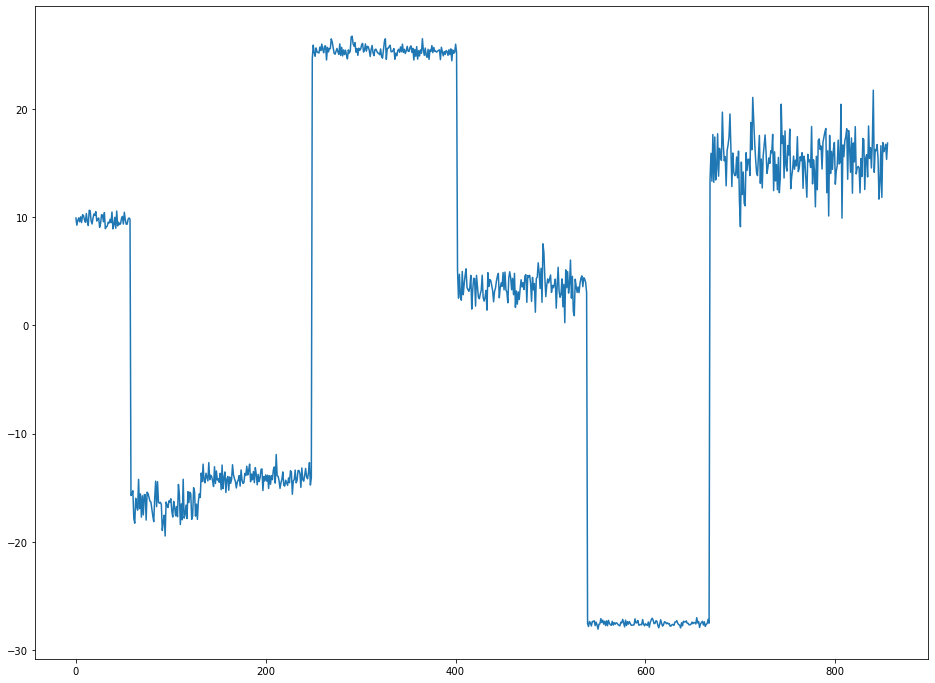

In [3]:
fig, ax = plt.subplots(figsize=[16, 12])
ax.plot(data)

In [5]:
from functools import partial
from bayesian_changepoint_detection.hazard_functions import constant_hazard
hazard_function = partial(constant_hazard, 250)

In [6]:
from bayesian_changepoint_detection.bayesian_models import online_changepoint_detection
import bayesian_changepoint_detection.online_likelihoods as online_ll

R, maxes = online_changepoint_detection(
    data, hazard_function, online_ll.StudentT(alpha=0.1, beta=.01, kappa=1, mu=0)
)

Use scipy logsumexp().


The online version computes slightly different things. For each time step it returns the probability distribution over the length of the last sequence. E.g. `R[7, 3]` is the probability at time step `7` that the last sequence is already `3` time steps long. It also returns the MAP estimate at each timestep for convenience.

To plot the distributions we use a grey-scale colormap, black is zero, white 1. We also plot the probability at each time step for a sequence length of 0, i.e. the probability of the current time step to be a changepoint.

Because it's very hard to correctly evaluate a change after a single sample of a new distribution, we instead can "wait" for `Nw` samples and evalute the probability of a change happening `Nw` samples prior.

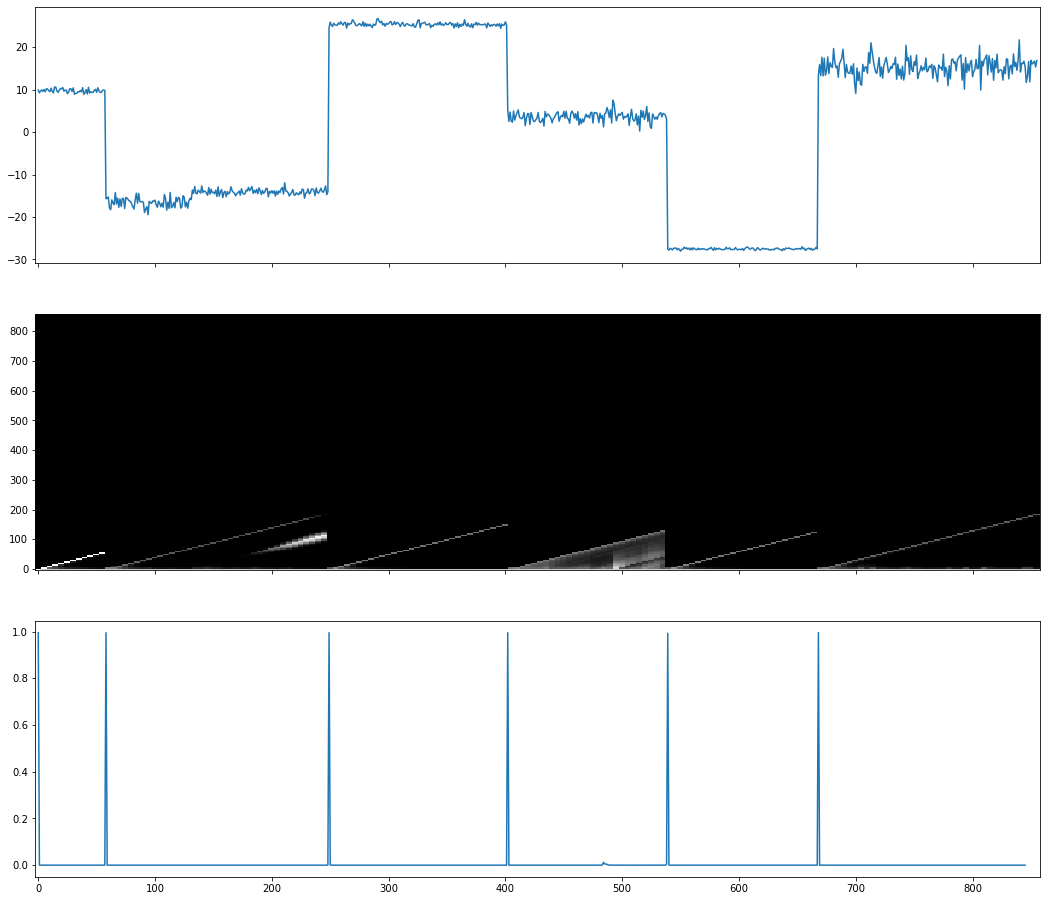

In [7]:
import matplotlib.cm as cm
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
ax[0].plot(data)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[2].plot(R[Nw,Nw:-1])

In [8]:
partition, data = generate_normal_time_series(7, 50, 200)

In [9]:
%timeit R, maxes = online_changepoint_detection(data, hazard_function, online_ll.StudentT(10, .03, 1, 0))

354 ms ± 76.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Real World Sample Evaluation 

In [20]:
import pandas as pd

stock_df= pd.read_excel('/Users/yuefeng/Desktop/研二/DS-GA 1018/ final project/DJIA(2018-2022).xlsx')
data= np.array(stock_df['Adj Close**']) - np.mean(stock_df['Adj Close**'])
stock_df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume,5 Year Key Event
0,2021-12-31,36385.85,36484.94,36303.97,36338.30,36338.30,213200000,NaN
1,2021-12-30,36522.48,36679.44,36372.13,36398.08,36398.08,205620000,NaN
2,2021-12-29,36421.14,36571.55,36396.19,36488.63,36488.63,213480000,NaN
3,2021-12-28,36302.99,36527.26,36302.99,36398.21,36398.21,239090000,NaN
4,2021-12-27,35954.48,36306.61,35954.48,36302.38,36302.38,244350000,NaN


In [21]:
R, maxes = online_changepoint_detection(
    data, hazard_function, online_ll.StudentT(alpha=0.5, beta=.05, kappa=1, mu=0)
)

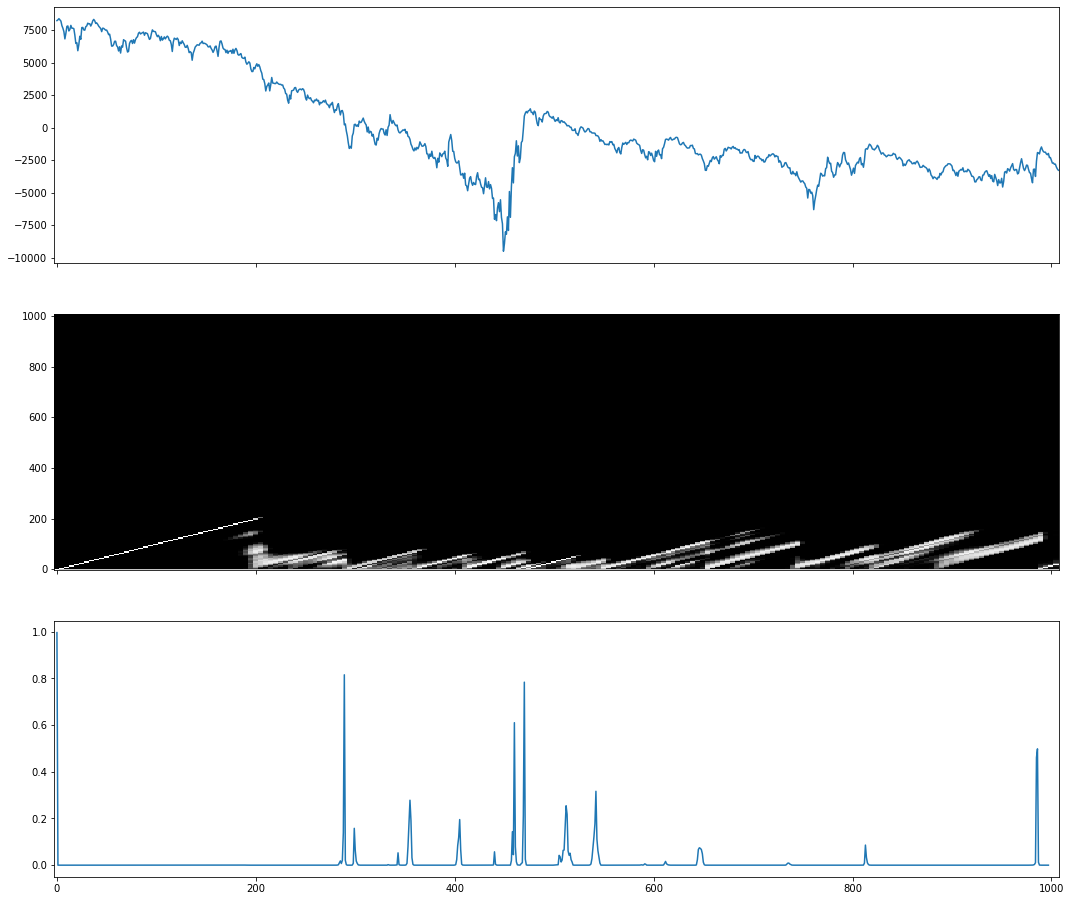

In [22]:
epsilon = 1e-7
fig, ax = plt.subplots(3, figsize=[18, 16], sharex=True)
ax[0].plot(data)
sparsity = 5  # only plot every fifth data for faster display
density_matrix = -np.log(R[0:-1:sparsity, 0:-1:sparsity]+epsilon)
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          density_matrix, 
          cmap=cm.Greys, vmin=0, vmax=density_matrix.max(),
            shading='auto')
Nw=10
ax[2].plot(R[Nw,Nw:-1])

In [46]:
import numpy as np
from scipy.special import loggamma
from math import pi

########### Normal setting ##########################
# prior = (mu0, kappa0, alpha0, beta0) 
# For precision shift model when mean is assumed to be known, put kappa0 to be a very large value
def calculatePosteriorNormal(x, prior):
      mu0 = prior[0]
      kappa0 = prior[1]
      alpha0 = prior[2]
      beta0 = prior[3]
      n = len(x)
      
      # Update posterior
      mu_n = mu0 + (kappa0*mu0+sum(x))/(kappa0+n)
      kappa_n = kappa0 + n
      alpha_n = alpha0 +n/2
      beta_n = beta0 + 1/2* np.sum((x-np.mean(x))^2)+(kappa0*n)*(np.mean(x)-mu0)^2/(2*(kappa0+n))
      
      # Calculate
      MeanMean = mu_n
      MeanPrecision = alpha_n/beta_n
      VarianceMean = 2*alpha_n/(2*alpha_n-2) * beta_n/(alpha_n*kappa_n)
      VariancePrecision=alpha_n/beta_n^2
      SMMean=MeanMean^2+VarianceMean
      SMPrecision=MeanPrecision^2 + VariancePrecision
      return {'MeanMean': MeanMean, 'MeanPrecision': MeanPrecision, 'SMMean': SMMean, 'SMPrecision':SMPrecision}

# Calculate PPD
#### Functions that are used to calculate PPD
def studentpdf(x, df, mu0, var):
      c = np.exp(loggamma(df/2 + 0.5) - loggamma(df/2)) * (df*pi*var)^(-0.5) 
      p = c * (1 + 1/(df*var)*(x-mu0)^2)^(-(df+1)/2)
      if np.isnan(p):
        print("NaN")
      return(p) 

def calculatePPDNormal(x, mu, kappa, alpha, beta):
        #nu and chi is a vector
      return studentpdf(x=x,df=2*alpha, mu0=mu, var=beta*(kappa+1)/(alpha*kappa)) 

### Beginning algorithm
# prior = (mu0, kappa0, alpha0, beta0)
def LEXO_normal(x, mu0, kappa0,alpha0,beta0, H, ell):
      prior =  [mu0, kappa0,alpha0,beta0]
      totalTime= len(x)
      # Rlist is list of R matrix; each element is R matrix for one lag; R[[1]] = EXO
      # Initialize R matrix and posterior mean matrix
      R = np.zeros((ell+1, totalTime, totalTime))
      # Theta is list of mean posterior P(theta_t | r_t, x_1:t+\ell), each element corresponds to one lag
      # SM is list of second moment posterior P(theta_t | r_t, x_1:t+\ell), each element corresponds to one lag
      MeanMean = SMMean = MeanPrecision=SMPrecision= np.zeros((ell+1, totalTime, totalTime))
      
      for i in range(0, ell+1):
        MeanMean[i] = SMMean[i]=MeanPrecision[i] = SMPrecision[i] = np.zeros(shape=(totalTime, totalTime))
        R[i] = np.zeros(shape=(totalTime, totalTime))
        R[i][0,0] = 1 
        
      # Constant hazard rate
      # predprobs: Keeping track of predictive probabilities P(x_t | r_t, x_{1:t-1}) at each time point 
      # P(r_t|x_1:t+1) \propto P(x_t+1 | r_t, x_1:t) P(r_t, x_1:t)
      # reg1 = P(x_t+1 | r_t, x_1:t): regularization term for lexo-1
      predprobs = []
      # We do not do anything for t=1
      predprobs.append(None)
      # Initialize prior hyperparameter
      muT = mu0
      kappaT = kappa0
      alphaT = alpha0
      betaT=beta0
      
      for t in range(totalTime+1):        
        if t==0: 
          # Update the sufficient statistics only
          muT0 =  [mu0, (kappaT*muT+x[t])/(kappaT+1)]
          kappaT0 =  [kappa0, kappaT+1]
          alphaT0 = [alpha0, alphaT+1/2]
          betaT0 = [beta0, betaT + kappaT*(x[t]-muT)^2/(2*(kappaT+1))]
          muT = muT0
          kappaT = kappaT0
          alphaT = alphaT0
          betaT = betaT0 
            
        else:
          # evaluate predictive probabilities P(x_t | r_t, x_1:t-1)
          predprobs[t] = calculatePPDNormal(x[t], muT, kappaT, alphaT, betaT)
          # Calculate growth probabilities
          R[0][1:t,t]= R[0][0:(t-1),t-1]*predprobs[t][-1]*(1-H)
          # Calculate changepoint probabilities
          # P(r_t=0, x_1:t)  \sum_{r_t-1} P(x_1:t-1, r_t-1) P(x_t|r_t=0, x_1:t-1) P(r_t|r_t-1)
          # Note that in the above sum, the sum is literally over the first term only
          R[0][0,t] = sum(R[0][0:(t-1),t-1])*predprobs[t][0]*H
          # Normalize
          R[0][:,t] = R[0][:,t]/sum(R[0][:,t])
          # Update sufficient statistics
          muT0 =  [mu0, (kappaT*muT+x[t])/(kappaT+1)]
          kappaT0 =  [kappa0, kappaT+1]
          alphaT0 =  [alpha0, alphaT+1/2]
          betaT0 = [beta0, betaT + kappaT*(x[t]-muT)^2/(2*(kappaT+1))]
          muT = muT0 
          kappaT = kappaT0
          alphaT = alphaT0
          betaT = betaT0 
          
        # Calculating EXO posterior mean parameter estimate
        Q= [calculatePosteriorNormal(x[(t-j):t], prior) for j in range(0,t)] 
        MeanMean[0][0:t,t]=  [q["MeanMean"] for q in Q]
        SMMean[0][0:t,t]= [q["SMMean"] for q in Q]
        MeanPrecision[0][0:t,t]= [q["MeanPrecision"] for q in Q]
        SMPrecision[0][0:t,t]= [q["SMPrecision"] for q in Q]
        #SM[[1]][1:t,t]= sapply(0:(t-1), function(j) calculatePosteriorSecondMoment(x[(t-j):t], prior=c(10^-4, 10^-4)))
        
        # LEXO algorithm
        for  j in range(ell+1):
          # Calculate run length
          if (t>=j+1): # LEXO-1 begins from t=2, LEXO-2 begins from t=3,...
            R[j+1][0:(t-j),t-j]=R[j][1:(t-j+1),t-j+1]+R[j][0,t-j+1]*R[0][0:(t-j),t-j]
            # Calculate posterior mean parameter estimate
            #### First calculate alpha 
            # Unnormalize version
            #\alpha = P(r_{t+1}=0 | r_t, x_{1:t\ell})
            alpha1 = 10^200 * R[0][0:(t-j),t-j]*R[j][0,t-j+1]#avoid underflow
            alpha2 = 10^200 * R[j][1:(t-j+1),t-j+1]
            alpha = alpha1/(alpha1+alpha2)
            alpha = np.where((alpha1==0), 0, alpha)
            #alpha = replace(alpha,which(alpha<1e-300),0)
            MeanMean[j+1][0:(t-j),t-j]=alpha*MeanMean[0][0:(t-j),t-j]+(1-alpha)*MeanMean[0][1:(t-j+1),t-j+1]
            MeanPrecision[j+1][0:(t-j),t-j]=alpha*MeanPrecision[0][0:(t-j),t-j]+(1-alpha)*MeanPrecision[j][1:(t-j+1),t-j+1]
            SMMean[j+1][0:(t-j),t-j]=alpha*SMMean[0][0:(t-j),t-j]+(1-alpha)*SMMean[j][1:(t-j+1),t-j+1]
            SMPrecision[j+1][0:(t-j),t-j]=alpha*SMPrecision[0][0:(t-j),t-j]+(1-alpha)*SMPrecision[j][1:(t-j+1),t-j+1]
        
      
      MeanMeanPosterior = np.sum(R @ MeanMean.T, 0) #mapply(function(x,y) apply(x*y,2,sum), x=R, y=MeanMean)
      SMMeanPosterior = np.sum(R @ SMMean.T, 0) #mapply(function(x,y) apply(x*y,2,sum), x=R, y=SMMean)
      
      MeanPrecisionPosterior = np.sum(R @ MeanPrecision.T, 0) #mapply(function(x,y) apply(x*y,2,sum), x=R, y=MeanPrecision)
      SMPrecisionPosterior = np.sum(R @ SMPrecision.T, 0) #mapply(function(x,y) apply(x*y,2,sum), x=R, y=SMPrecision)
      
      VarMeanPosterior =  SMMeanPosterior-MeanMeanPosterior**2
      VarPrecisionPosterior= SMPrecisionPosterior-MeanPrecisionPosterior**2 
      
      return {'RunLength': R, 'PosPrecision': list(Mean=MeanPrecisionPosterior, Variance=VarPrecisionPosterior),
                  'PosMean':list(Mean=MeanMeanPosterior,Variance=VarMeanPosterior)}


In [47]:
LEXO_normal(data, 0, 1,0.5,0.05, H=1/250, ell=30)


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''